# Multi-Component 2-D Gaussian Fitting — Tutorial

This notebook demonstrates the major features of:

- `astroviper.fitting.multi_gaussian2d_fit.fit_multi_gaussian2d`
- `astroviper.fitting.multi_gaussian2d_fit.plot_components` (if available)

You’ll learn how to:
- Fit one or many 2-D Gaussians (sum of components) to images or data cubes
- Use NumPy, Dask, or Xarray inputs and vectorize over extra dims
- Provide initial guesses (array / list-of-dicts / dict-with-components)
- Apply bounds (including fixing parameters with equal bounds)
- Use thresholds to mask pixels during the fit
- Work with angle conventions: `"math"`, `"pa"`, and `"auto"`
- Get world coordinates of centroids when axis coords are provided
- Return fitted model plane(s) and residuals

**Tip:** Run cells top-to-bottom. All cells are self-contained and documented.

## 0) Imports & Utilities

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt

from astroviper.fitting.multi_gaussian2d_fit import fit_multi_gaussian2d
from astroviper.model.component_models import make_gauss2d

from astroviper.fitting.multi_gaussian2d_fit import plot_components
from astroviper.utils.plotting import plot_correct_orientation

# Reproducibility
rng = np.random.default_rng(1234)

### Utility: synthetic Gaussian scenes
Helpers used only to generate synthetic test images for this tutorial.

In [2]:
def make_scene_via_component_models(
    ny: int,
    nx: int,
    components: list[dict],
    *,
    offset: float = 0.1,
    noise_std: float = 0.02,
    seed: int | None = None,
    coords: bool = True,
    angle: str = "math",  # "math" | "pa" | "auto" — same semantics as astroviper's model
    x_world: tuple[float, float] = (0.0, 1.0),
    y_world: tuple[float, float] = (0.0, 1.0),
) -> xr.DataArray:
    """
    Build a synthetic image using astroviper.model.component_models.(make_gaussian|make_gauss2d).

    components: list of dicts with keys:
      {"amp"/"amplitude","x0","y0","sigma_x","sigma_y","theta"}.
    """
    rng = np.random.default_rng(seed)
    # coords
    if coords:
        x0, x1 = x_world
        y0, y1 = y_world
        x = np.linspace(x0, x1, nx, dtype=float)
        y = np.linspace(y0, y1, ny, dtype=float)
    else:
        x = np.arange(nx, dtype=float)
        y = np.arange(ny, dtype=float)
    print("x", x)
    # accumulate model in float64
    z = np.zeros((ny, nx), dtype=float)
    for c in components:
        amp = float(c.get("amp", c.get("amplitude")))
        x0c = float(c["x0"])
        y0c = float(c["y0"])
        fwhm_x = float(c["fwhm_major"])
        fwhm_y = float(c["fwhm_minor"])
        thc = float(c.get("theta", 0.0))

        # astroviper's generator uses coords + angle convention, returns (ny,nx)
        z = make_gauss2d(
            data=z,
            a=fwhm_x,
            b=fwhm_y,
            theta=thc,
            x0=x0c,
            y0=y0c,
            peak=amp,
            x_coord="x",
            y_coord="y",
            coords={"x": x, "y": y},
            add=True,
            angle=angle,
        )

    z += float(offset)
    print("max", z.max())
    print("noise_std", noise_std)
    if noise_std > 0:
        z += rng.normal(scale=noise_std, size=z.shape)

    da = xr.DataArray(z, dims=("y", "x"))
    if coords:
        da = da.assign_coords(x=x, y=y)
    return da

## 1) Fit one Gaussian in noiseless image to prove functionality

x [-128. -126. -124. -122. -120. -118. -116. -114. -112. -110. -108. -106.
 -104. -102. -100.  -98.  -96.  -94.  -92.  -90.  -88.  -86.  -84.  -82.
  -80.  -78.  -76.  -74.  -72.  -70.  -68.  -66.  -64.  -62.  -60.  -58.
  -56.  -54.  -52.  -50.  -48.  -46.  -44.  -42.  -40.  -38.  -36.  -34.
  -32.  -30.  -28.  -26.  -24.  -22.  -20.  -18.  -16.  -14.  -12.  -10.
   -8.   -6.   -4.   -2.    0.    2.    4.    6.    8.   10.   12.   14.
   16.   18.   20.   22.   24.   26.   28.   30.   32.   34.   36.   38.
   40.   42.   44.   46.   48.   50.   52.   54.   56.   58.   60.   62.
   64.   66.   68.   70.   72.   74.   76.   78.   80.   82.   84.   86.
   88.   90.   92.   94.   96.   98.  100.  102.  104.  106.  108.  110.
  112.  114.  116.  118.  120.  122.  124.  126.  128.]
max 5.0
noise_std 0


<xarray.DataArray ()> Size: 8B
array(5.)

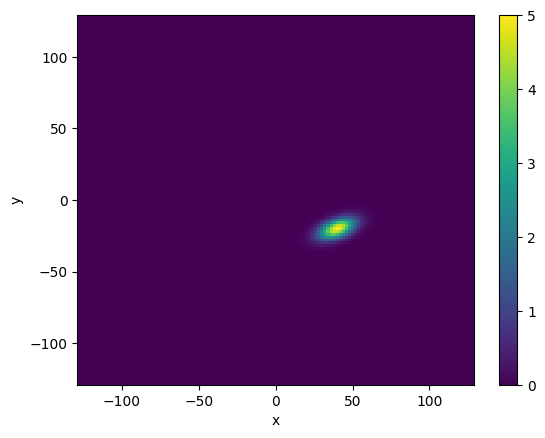

In [3]:
nx = 129
ny = 129

comp = [
    dict(amp=5.0, x0=40, y0=-20, fwhm_major=20.0, fwhm_minor=10.0, theta=0.4)
]

data = make_scene_via_component_models(
    ny=ny,
    nx=nx,
    components=comp,
    offset=0.0,
    noise_std=0,
    x_world=(-nx+1, nx-1),
    y_world=(-ny+1, ny-1),
)

plot_correct_orientation(data, "x", "y")
data.max()

In [4]:
guess = {
    "amp": 5.0, "x0": 40.0, "y0": -20.0,
    "fwhm_major": 20.0, "fwhm_minor": 10.0, "theta": 0.4
}

fit = fit_multi_gaussian2d(
    data, n_components=1, initial_guesses=comp, return_residual=True, return_model=True
)
"""
fit = fit_multi_gaussian2d(
    data, n_components=1, return_residual=True, return_model=True
)
"""
print("Input model:", comp[0])
fit

Input model: {'amp': 5.0, 'x0': 40, 'y0': -20, 'fwhm_major': 20.0, 'fwhm_minor': 10.0, 'theta': 0.4}


<xarray.Dataset> Size: 268kB
Dimensions:             (component: 1, x: 129, y: 129)
Coordinates:
  * x                   (x) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
  * y                   (y) float64 1kB -128.0 -126.0 -124.0 ... 126.0 128.0
Dimensions without coordinates: component
Data variables: (12/25)
    amplitude           (component) float64 8B 5.0
    x0                  (component) float64 8B 40.0
    y0                  (component) float64 8B -20.0
    fwhm_major          (component) float64 8B 20.0
    fwhm_minor          (component) float64 8B 10.0
    sigma_x             (component) float64 8B 8.493
    ...                  ...
    success             bool 1B True
    variance_explained  float64 8B 1.0
    residual            (y, x) float64 133kB 1.232e-19 1.232e-19 ... 1.232e-19
    model               (y, x) float64 133kB -1.232e-19 ... -1.232e-19
    x_world             (component) float64 8B -48.0
    y_world             (component) float64 8B -128.0
Attributes:
    theta_convention:  math
    axes_handedness:   right
    angle_input:       math

## 2) Basic: Fit two Gaussians on a 2-D image
- Xarray `DataArray` with dims `("y","x")`.
- Initial guesses as `(N,6)` array: `[amp, x0, y0, sigma_x, sigma_y, theta]`.
- Get parameters, uncertainties, derived metrics + diagnostics.

In [ ]:
ny, nx = 128, 128
true = [
    {"amp": 1.0, "x0": 42.0, "y0": 60.0, "fwhm_x": 3.0, "fwhm_y": 3.0, "theta": 0.0},
    {"amp": 0.7, "x0": 92.0, "y0": 35.0, "fwhm_x": 5.0, "fwhm_y": 2.5, "theta": 0.4},
]
img = make_scene_via_component_models(ny, nx, true, offset=0.12, noise_std=0.03, coords=True)

ax = img.plot.imshow(origin="lower", robust=True)  # robust=True avoids outlier stretch
ax.axes.set_title("Raw image")
ax.axes.set_aspect("equal")

init_arr = np.array(
    [
        [0.9, 40.0, 61.0, 3.0, 3.0, 0.0],
        [0.6, 90.0, 34.0, 4.8, 2.7, 0.4],
    ],
    dtype=float,
)

ds_basic = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, return_residual=True, return_model=True
)
print("Input model: ", comp[0])
ds_basic

### Quicklook: visualize data, model, residual (if `plot_components` is available)

In [ ]:
if plot_components is not None:
    plot_components(img, ds_basic, dims=("x", "y"), show_residual=True)
else:
    print("plot_components helper is not available in this build.")

## 3) Threshold masking
Ignore pixels outside inclusive `[min_threshold, max_threshold]` during the fit.

In [ ]:
img_thr = img.copy()
img_thr.values[img_thr.values < 0.11] = 0.05
ds_thr = fit_multi_gaussian2d(
    img_thr, n_components=2, initial_guesses=init_arr, min_threshold=0.1, max_threshold=None
)
float(ds_thr.variance_explained)

## 4) Initial guesses formats
Forms:
- **Array (N,6)** — used above.
- **List of N dicts** — supports key synonyms.
- **Dict with `"components"`** — optional `"offset"` seed.
Angles in `initial_guesses` are interpreted per `angle=`.

In [ ]:
# (b) list of dicts
init_list = [
    {"amp": 0.95, "x0": 41.5, "y0": 60.5, "sigma_x": 3.0, "sigma_y": 3.0, "theta": 0.0},
    {"amplitude": 0.68, "x0": 92.5, "y0": 34.5, "sx": 5.0, "sy": 2.5, "theta": 0.4},
]
ds_list = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_list)

# (c) dict with 'components' and 'offset'
init_dict = {"offset": 0.12, "components": init_arr}
ds_dict = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_dict)

float(ds_list.success), float(ds_dict.offset)

## 5) Bounds (and fixing parameters)
- Dict mapping names → `(low, high)` **or** per-component list of tuples.
- To **fix** a value, use equal bounds `(v, v)`.

In [ ]:
bounds_all = {"amplitude": (0.4, 1.5)}
bounds_per = {"sigma_x": [(2.5, 3.5), (4.0, 6.0)]}

ds_bounds_all = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_all)
ds_bounds_per = fit_multi_gaussian2d(img, n_components=2, initial_guesses=init_arr, bounds=bounds_per)

ds_fix_offset = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, bounds={"offset": (0.12, 0.12)}
)
float(ds_fix_offset.offset)

## 6) Return model and residual
- `return_model=True` → `ds["model"]`
- `return_residual=True` → `ds["residual"] = data - model`

In [ ]:
ds_planes = fit_multi_gaussian2d(
    img, n_components=2, initial_guesses=init_arr, return_model=True, return_residual=True
)
ds_planes["model"], ds_planes["residual"]

## 7) Angle conventions: `"math"`, `"pa"`, `"auto"`
- `"math"`: θ from +x → +y (CCW) in data axes.
- `"pa"`: position angle from +y → +x.
- `"auto"`: detect left-handed axes (descending/ascending) and use PA; else math.
Inputs interpret `theta` per `angle`, outputs reported in the same convention.

In [ ]:
# Fit with PA conventions; seeds given in PA
pa_init = [{
    "amp": 1.0, "x0": 42.0, "y0": 60.0, "sigma_x": 3.0, "sigma_y": 2.2,
    "theta": float(np.arctan2(np.cos(0.5), np.sin(0.5)))
}]
ds_pa = fit_multi_gaussian2d(img, n_components=1, initial_guesses=pa_init, angle="pa")
float(ds_pa.theta)

In [ ]:
# AUTO: make a left-handed grid by flipping 'y' coords; AUTO chooses PA here
img_desc_y = img.assign_coords(y=img.y.values[::-1])
ds_auto = fit_multi_gaussian2d(img_desc_y, n_components=1, initial_guesses=pa_init, angle="auto")
float(ds_auto.theta)

## 8) Vectorized fitting over extra dims
N-D inputs are fit per-plane across all leading dims; specify plane dims with `dims=("x","y")` if needed.

In [ ]:
planes = [img + 0.01 * rng.normal(size=img.shape) for _ in range(3)]
cube = xr.concat(planes, dim="time")  # dims: ('time','y','x')

ds_cube = fit_multi_gaussian2d(cube, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
ds_cube

## 9) Dask-backed arrays
Accepts Dask arrays and parallelizes via `xarray.apply_ufunc(dask="parallelized")`.

In [ ]:
cube_np = np.stack([(img + 0.01 * rng.normal(size=img.shape)).values for _ in range(4)], axis=0)
cube_da = xr.DataArray(da.from_array(cube_np, chunks=(2, img.shape[0], img.shape[1])), dims=("time", "y", "x"))

ds_dask = fit_multi_gaussian2d(cube_da, n_components=2, initial_guesses=init_arr, dims=("x", "y"))
float(ds_dask["amplitude"].mean().compute())

## 10) World coordinates of centroids
If both fit axes have 1-D numeric coords, results include `x_world(component)` and `y_world(component)`.

In [ ]:
("x_world" in ds_basic and "y_world" in ds_basic), ds_basic.get("x_world"), ds_basic.get("y_world")

## 11) Error handling & tips
- `n_components` ≥ 1.
- N-D arrays without `(\"x\",\"y\")` dims: pass `dims=(x_dim, y_dim)`.
- Initial guesses length/shape must match `n_components`.
- Bounds: per-component list must be length N; to fix a value, use `(v, v)`.
- Performance: reasonable seeds & tight bounds; adjust `max_nfev`; with Dask, tune chunking/scheduler.